In [2]:
import os
from typing import List
import pandas as pd

import nnts
import nnts.data
import nnts.experiments
from nnts import utils, datasets
import nnts.torch.preprocessing as preprocessing
import nnts.torch.models
import trainers
import nnts.metrics
import nnts.torch.datasets
import nnts.loggers
import covs 
import nnts.datasets
import nnts
import torch.nn.functional as F
import nnts.torch.utils
import torch.optim
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_path = "data"
model_name = "seg-lstm"
dataset_name = "hospital"
results_path = "nb-results"
metadata_path = os.path.join(data_path, f"{model_name}-monash.json")
metadata = datasets.load_metadata(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.datasets.read_tsf(datafile_path)
params = utils.Hyperparams(optimizer=torch.optim.AdamW,loss_fn=F.smooth_l1_loss )

utils.makedirs_if_not_exists(PATH)

In [3]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )

# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

scenario_list.append(
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, 0, covariates=3, skip=1
    )
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: garethmd. Use `wandb login --relogin` to force relogin


SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(12, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=12, bias=True)
    )
  )
)
early stopping
Run cov-0-pearsn-0-pl-12-seed-42 finished


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


abs_error,▁
abs_target_mean,▁
abs_target_sum,▁
mae,▁
mape,▁
mase,▁
mse,▁
nd,▁
rmse,▁
seasonal_error,▁
smape,▁


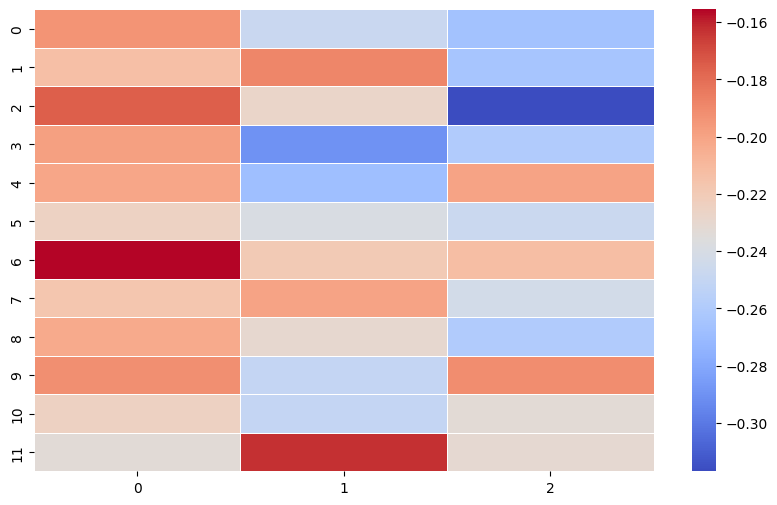

In [4]:
for scenario in scenario_list[:1]:
    params.batches_per_epoch = 500
    nnts.torch.utils.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    trn_dl, val_dl, test_dl = nnts.torch.utils.create_dataloaders(
        df,
        nnts.datasets.split_test_val_train_last_horizon,
        metadata.context_length,
        metadata.prediction_length,
        Dataset=nnts.torch.datasets.TimeseriesDataset,
        dataset_options={
            "context_length": metadata.context_length,
            "prediction_length": metadata.prediction_length,
            "conts": scenario.conts,
        },
        batch_size=params.batch_size,
    )
    logger = nnts.loggers.WandbRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = covs.model_factory(model_name, params, scenario, metadata)

    trner = trainers.ValidationTorchEpochTrainer(
        trainers.TrainerState(), 
        net, 
        params, 
        metadata, 
        os.path.join(PATH, f"{scenario.name}.pt"),
        loss_fn=F.smooth_l1_loss
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl, val_dl)
    handle = net.decoder.register_forward_hook(logger.log_activations)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length, hooks=handle
    )
    handle.remove()
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, nnts.metrics.calculate_seasonal_error(trn_dl, metadata)
    )
    logger.log(test_metrics)
    logger.finish()

In [ ]:
csv_aggregator = nnts.datasets.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [ ]:
results = pd.read_csv(f"{PATH}/results.csv")
results

In [ ]:
import nnts.experiments.plotting


df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = nnts.experiments.plotting.plot(df_list, scenario.prediction_length)

In [ ]:
univariate_results = results.loc[
    (results["covariates"] == 0)
    & (results["prediction_length"] == metadata.prediction_length),
    ["smape", "mape", "rmse", "mae"],
]

univariate_results.mean(), univariate_results.std(), univariate_results.count()

In [ ]:
cols = ["dataset", "error", "pearson", "covariates", "prediction_length", "smape"]

In [ ]:
results.loc[
    (results["covariates"] > 0)
    & (results["error"].isin([0.000000, 0.4714285714285714, 1.65])),
    cols,
].sort_values(by=['covariates', 'error'])

In [ ]:
sorted(results["error"].unique().tolist())

In [ ]:
import numpy as np
np.linspace(0, 0.6, 8).tolist()